In [1]:
import cv2
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

from craterdetection import template_match_t
from VPU import NCSInferenceHandler

exp = NCSInferenceHandler('DeepMoon', device='MYRIAD')

img = cv2.imread('sample_data/test_input.png', cv2.IMREAD_GRAYSCALE)
batch = transforms.ToTensor()(img).unsqueeze_(0)
exp

(MYRIAD):
        MKLDNNPlugin version: 2.1
        tBuild: 2021.1.0-1237-bece22ac675-releases/2021/1
        tModel info:
        	Input layout: NCHW
        	Input shape: (1, 1, 256, 256)
        

In [28]:
%%time
out = exp.infer(batch)
extracted_rings = template_match_t(out[0,0].copy(), minrad=2.5)

Wall time: 2.11 s


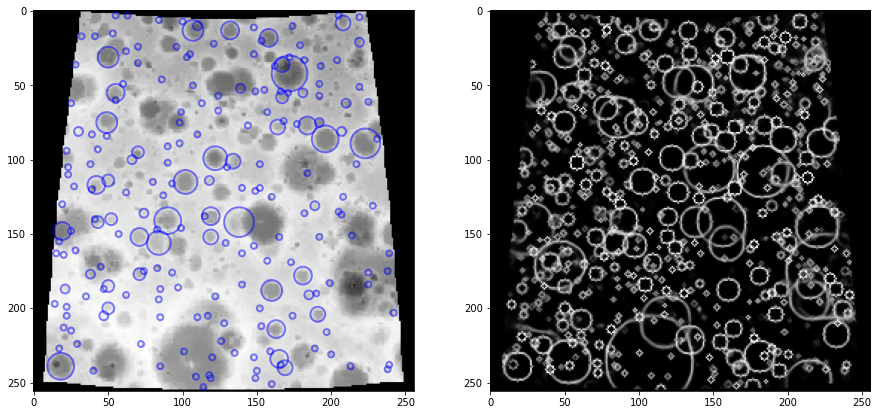

In [29]:
fig, axes = plt.subplots(1,2, figsize=(15,15))

for x, y, r in extracted_rings:
    circle = plt.Circle((x, y), r, color='blue', fill=False, linewidth=2, alpha=0.5)
    axes[0].add_artist(circle)

axes[0].imshow(img, cmap='Greys_r')
axes[1].imshow(out[0,0], cmap='Greys_r')

In [26]:
# detect circles in the image
output = img.copy()
circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1.2, 100)
# ensure at least some circles were found
if circles is not None:
	# convert the (x, y) coordinates and radius of the circles to integers
	circles = np.round(circles[0, :]).astype("int")
	# loop over the (x, y) coordinates and radius of the circles
	for (x, y, r) in circles:
		# draw the circle in the output image, then draw a rectangle
		# corresponding to the center of the circle
		cv2.circle(output, (x, y), r, (0, 255, 0), 4)
		cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)


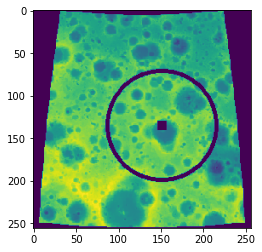

In [27]:
plt.imshow(output)